In [1]:
## Process AlpArray Switzerland for SKS-Splitting
## Gerrit Hein
######################################################
######### LOAD IN THE MODULES
######################################################
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import matplotlib.pyplot as plt
import numpy as np

import os
import obspy
from obspy import read
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import TauPyModel
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.taup import plot_travel_times
from obspy.geodetics import locations2degrees
from obspy.signal.rotate import rotate_ne_rt
from obspy.signal.polarization import particle_motion_odr

from obspy.signal.util import next_pow_2

import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

from matplotlib.mlab import specgram
from scipy import stats

from itertools import izip_longest as zip_longest
#from itertools import zip_longest as zip_longest


from tqdm import tqdm
import time

import multiprocessing
import seaborn as sns
import scipy
import pandas as pd
import splitwavepy as sw
######################################################
### 
######################################################



In [2]:
### FUNCTIONS TO LOAD IN THE RESULTS

def calc_u_v(r,phi):
    
    if (phi>=0 and phi<=90):
        phi=90-phi
        u = r*np.cos(np.deg2rad(phi))
        v = r*np.sin(np.deg2rad(phi))
    elif (phi>90 and phi<=180):
        phi=180-phi
        u = r*np.sin(np.deg2rad(phi))
        v = -r*np.cos(np.deg2rad(phi))    
    elif (phi>180 and phi<=270):
        phi=270-phi
        u = -r*np.cos(np.deg2rad(phi))
        v = -r*np.sin(np.deg2rad(phi))    
    elif (phi>270 and phi<=360):
        phi=360-phi
        u = -r*np.sin(np.deg2rad(phi))
        v = r*np.cos(np.deg2rad(phi))    
    elif (phi>=-90 and phi<0):
        phi=abs(phi)
        u = -r*np.sin(np.deg2rad(phi))
        v = r*np.cos(np.deg2rad(phi))            
    elif (phi>=-180 and phi<-90):
        phi=180-abs(phi)
        u = -r*np.sin(np.deg2rad(phi))
        v = -r*np.cos(np.deg2rad(phi))                    
        
    return u,v

def read_SKS_files(path,filename):
    filename = '{0}/{1}'.format(path,filename) #removed first two header lines
    with open(filename) as f:
        content = f.readlines()

    station = ['']*len(content) 
    dt = ['']*len(content) 
    dtlag  = ['']*len(content) 
    fast_dir = ['']*len(content) 
    dfast_dir = ['']*len(content)
    best_twin = ['']*len(content)
    chi_phi = ['']*len(content) 
    chi_dt = ['']*len(content) 
    p_phi = ['']*len(content) 
    p_dt = ['']*len(content) 
    n_events = ['']*len(content) 
    

    for i in range(1,len(content)):
        data = zip_longest(*(x.split(' ') for x in content[i].splitlines()), fillvalue='\t')

        for row in zip(*data):
            new_data = tuple(np.nan if x == '' else x for x in row)
            line = new_data
            station[i] = line[0][1:-1]            
            fast_dir[i] = float(line[1][1:-2])            
            dfast_dir[i] = float(line[2][1:-2])                                    
            dt[i] = float(line[3][1:-2])
            dtlag[i] = float(line[4][1:-2])          
            best_twin[i] = float(line[5][1:-2])          
            chi_phi[i] = float(line[6][1:-2]) 
            p_phi[i] = float(line[7][1:-2]) 
            chi_dt[i] = float(line[8][1:-2]) 
            p_dt[i] = float(line[9][1:-2])  
            n_events[i] = float(line[10][1:-1])

    station = np.asarray(station[1:])
    dt = np.asarray(dt[1:])
    dtlag = np.asarray(dtlag[1:])
    fast_dir = np.asarray(fast_dir[1:])
    ## convert from -90-90 to 0-180    
    fast_dir = (fast_dir+180)%180    
    dfast_dir = np.asarray(dfast_dir[1:])    
    best_twin = np.asarray(best_twin[1:])    
    chi_phi = np.asarray(chi_phi[1:])
    chi_dt = np.asarray(chi_dt[1:])
    p_phi = np.asarray(p_phi[1:])
    p_dt = np.asarray(p_dt[1:]) 
    n_events = np.asarray(n_events[1:]) 

        
    return station,dt,dtlag,fast_dir,dfast_dir,best_twin,chi_phi,p_phi,chi_dt,p_dt,n_events



# Function to read in OTHER SKS Files 

def read_SKS_methods(save_loc,method,station):
    
    filename= 'SKS_Splitting_{0}_{1}.txt'.format(station,method)
    filepath = '{0}/{1}/{2}'.format(save_loc,method,filename)

    
#    filename = '{0}/{1}'.format(path,filename) #removed first two header lines
    with open(filepath) as f:
        content = f.readlines()

    station = ['']*len(content) 
    st_lat  = ['']*len(content)
    st_lon = ['']*len(content)
    ev_time = ['']*len(content)
    ev_depth = ['']*len(content)
    ev_mag = ['']*len(content)
    ev_lat = ['']*len(content)
    ev_lon = ['']*len(content)
    fast_dir = ['']*len(content)
    dfast_dir = ['']*len(content)
    lag = ['']*len(content)
    dlag = ['']*len(content)
    SNR  = ['']*len(content)
    ### 
    window_param_t1 = ['']*len(content)
    window_param_t2 = ['']*len(content)
    chi_phi = ['']*len(content) 
    chi_dt = ['']*len(content) 
    p_phi = ['']*len(content) 
    p_dt = ['']*len(content)
        
    
    for i in range(1,len(content)):
        data = zip_longest(*(x.split(' ') for x in content[i].splitlines()), fillvalue='\t')
        for row in zip(*data):
            new_data = tuple(np.nan if x == '' else x for x in row)
            line = new_data
            station[i] = line[0][1:-1]            

            st_lat[i] = float(line[1][1:-1])
            st_lon[i] = float(line[2][1:-1]) 
            ev_time[i] = UTCDateTime(float(line[3][1:-1]))          
            ev_depth[i] = float(line[4][1:-1])  
            ev_mag[i] = float(line[5][1:-1])  
            ev_lat[i] = float(line[6][1:-1])  
            ev_lon[i] = float(line[7][1:-1])  
            fast_dir[i] = float(line[8][1:-1])  
            dfast_dir[i] = float(line[9][1:-1])  
            lag[i] = float(line[10][1:-1])  
            dlag[i] = float(line[11][1:-1])        
            SNR[i] = float(line[12][1:-1]) 
            window_param_t1[i] = float(line[13][1:-1])             
            window_param_t2[i] = float(line[14][1:-1])             
            chi_phi[i] = float(line[15][1:-1])             
            p_phi[i] = float(line[16][1:-1])             
            chi_dt[i] = float(line[17][1:-1])             
            p_dt[i] = float(line[18][1:-1])                    


    station = np.asarray(station[1:])
    st_lat = np.asarray(st_lat[1:])
    st_lon = np.asarray(st_lon[1:])
    ev_time = np.asarray(ev_time[1:])
    ev_depth = np.asarray(ev_depth[1:])
    ev_mag = np.asarray(ev_mag[1:])
    ev_lat = np.asarray(ev_lat[1:])
    ev_lon = np.asarray(ev_lon[1:])
    
    fast_dir = np.asarray(fast_dir[1:])
    ## convert from -90-90 to 0-180
    fast_dir = (fast_dir+180)%180
    
    dfast_dir = np.asarray(dfast_dir[1:])
    lag = np.asarray(lag[1:])
    dlag = np.asarray(dlag[1:])
    SNR = np.asarray(SNR[1:])

    window_param_t1 = np.asarray(window_param_t1[1:])
    window_param_t2 = np.asarray(window_param_t2[1:])
    chi_phi = np.asarray(chi_phi[1:])
    p_phi = np.asarray(p_phi[1:])            
    chi_dt = np.asarray(chi_dt[1:])

    p_dt = np.asarray(p_dt[1:]) 
    
    
    return station,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir,dfast_dir,lag,dlag,SNR,window_param_t1,window_param_t2,chi_phi,p_phi,chi_dt,p_dt


In [3]:

def get_Swiss_station_coordinates():
    
    save_loc = '/media/hein/home2/SplitWave_Data'
    station_list = os.listdir(save_loc)
    save_dir = '/media/hein/home2/SplitWave_Results/Splitws/backup/Time_Window_Test/TXT/'

    station = []
    station_lat = []
    station_lon = []

    for istation in tqdm(station_list):
    # for istation in tqdm(station_list[0:8]):       400
        method = ['CrossC','TransM','EigM']
        method = method[0]

        station_meth,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir,dfast_dir,lag,dlag,SNR,window_param_t1,window_param_t2,chi_phi,p_phi,chi_dt,p_dt = read_SKS_methods(save_dir,method,istation)    

        station =np.append(station,station_meth)
        station_lat = np.append(station_lat,st_lat)
        station_lon = np.append(station_lon,st_lon)


    station_ls = np.asarray(station)
    station_lat = np.asarray(station_lat)
    station_lon = np.asarray(station_lon)

    path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT'
    filename = 'SKS_Splitting_Chevrot_copy.txt'
    station_chev,dt,dtlag,fast_dir,dfast_dir,best_twin,chi_phi,p_phi,chi_dt,p_dt,n_events = read_SKS_files(path,filename)

    return station_chev,station_lat,station_lon




In [4]:

### FIRST LOAD IN THE BARRUOL RESULTS
## load in Barruol values
import csv

def load_in_Barruol_table(path):  

    station = ['']*60
    lat = ['']*60
    lon = ['']*60
    fast = ['']*60
    dfast= ['']*60
    lag= ['']*60
    dlag= ['']*60
    nSKS = ['']*60

    with open(path+'Barruol_values.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
    #        print(row)
            if line_count == 0:
                line_count += 1
            else:
                station[line_count] = row[0]
                lat[line_count] = float(row[1])
                lon[line_count] = float(row[2])
                a = ['1','2','3','4','5','6','7','8','9','0']
                if row[3][0] in a:
                    fast[line_count] = float(row[3][-5:])
                else:
                    fast[line_count] = -1*float(row[3][-5:])

                dfast[line_count] = float(row[4])
                lag[line_count] = float(row[5])
                dlag[line_count] = float(row[6])
                nSKS[line_count] = float(row[7])            

                line_count += 1
    #     print(f'Processed {line_count} lines.')
    station = filter(None, station)
    lat = filter(None, lat)
    lon = filter(None, lon)
    fast = filter(None, fast)
    dfast = filter(None, dfast)
    lag = filter(None, lag)
    dlag = filter(None, dlag)
    nSKS = filter(None, nSKS)
    
    station = np.asarray(station)
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    fast = np.asarray(fast)
    dfast = np.asarray(dfast)
    lag = np.asarray(lag)
    dlag = np.asarray(dlag)
    nSKS = np.asarray(nSKS)
    

    
    return station,lat,lon,fast,dfast,lag,dlag,nSKS



In [6]:
station_chev,station_lat,station_lon = get_Swiss_station_coordinates()
print(len(station_chev))
    
#station,lat,lon,fast,dfast,lag,dlag,nSKS = load_in_Barruol_table(path)
#print(station,lat,lon,fast,dfast,lag,dlag,nSKS)

100%|██████████| 40/40 [00:00<00:00, 2810.58it/s]

40


In [43]:
## Tasks: 
## make a Plan:

### after having best window run the chi squared test for chevrot 
## --> read results, take best timewindow
## --> read Waveforms
## --> run Chevrot again, with variable number of Events
## --> calc chi_squared of the fit for that 

## --> https://stackoverflow.com/questions/52591979/how-to-obtain-the-chi-squared-value-as-an-output-of-scipy-optimize-curve-fit
## --> write out Chi-Square for Hyp: Vals fit Gaussian Sinosoid, 

## plot number of Events vs chi-Squared


### comparison with tw analysis from others
## weighted histograms of 3 methods with best fit of Chevrot and Barruol
## get some statement about it 



### plot Switzerland maps
## best Chevrot vs Barruol
## best of the other three
## directions of fast axis
## length of dt
## Balls of Chi-Squared


### AND THEN START WRITING IT DOWN AGAIN
### READ MORE, GET NEW IDEAS


In [156]:
path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT'
#filename = 'SKS_Splitting_Chevrot_copy.txt'
filename = 'SKS_Splitting_Chevrot.txt'

station_chev,dt,dtlag,fast_dir,dfast_dir,best_twin,chi_phi,p_phi,chi_dt,p_dt,n_events = read_SKS_files(path,filename)

print(len(station_chev))

25


In [179]:
station_chev,dt,dtlag,fast_dir_chev,dfast_dir_chev,best_twin,chi_phi_chev,p_phi_chev,chi_dt,p_dt_chev,n_events = read_SKS_files(path,filename)
print(fast_dir_chev[np.where(station_chev==istation)])

[ 50.7896676]


In [8]:
# print(station_barr)
# print(istation)

# istation='HASLI'


# if istation in station_barr:
#     station_barr.index(istation)
#     print('yes')
#     print(station_barr.index(istation))
    


In [10]:
####################################
####################################
#### MAKE THE COMPARISON
####################################
####################################
### READ IN THE OTHER RESULTS, LOAD IN THE BACKUPS
path = '/media/hein/home2/SKS_automatic_splitwave/code_latest/'
station_barr,lat,lon,fast_barr,dfast_barr,lag_barr,dlag_barr,nSKS = load_in_Barruol_table(path)
station_barr = station_barr.tolist()

path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT'
#filename = 'SKS_Splitting_Chevrot_copy.txt'
filename = 'SKS_Splitting_Chevrot.txt'

station_chev,dt,dtlag,fast_dir_chev,dfast_dir_chev,best_twin,chi_phi_chev,p_phi_chev,chi_dt,p_dt_chev,n_events = read_SKS_files(path,filename)


save_loc = '/media/hein/home2/SplitWave_Data'
#save_loc = '/home/rud/Dropbox/PhD/code_PhD/SplitWave'
station_list = os.listdir(save_loc)

save_dir = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT/'
#save_dir = '/home/rud/Dropbox/PhD/code_PhD/SplitWave_Results/Comparison'
#station = station_list[np.random.randint(0,len(station_list))]

## for all three methods

#best_val_2 = [len(station_list),4]
#best_val_3 = [len(station_list),4]

nbins=25
c1 = 'cornflowerblue'
c2 = 'red'
method = ['CrossC','TransM','EigM']
#method = method[2]

#c1 = 'cornflowerblue'
count=0
best_val_1 = np.zeros((len(station_list),4))
best_val_2 = np.zeros((len(station_list),4))
best_val_3 = np.zeros((len(station_list),4))

for istation in tqdm(station_list):    

    
    #    print(station)
    fig = plt.figure(figsize=(16,9))
    plt.rcParams.update({'font.size': 11})
    for imethod in range(0,3):
        method = ['CrossC','TransM','EigM']
        c1 = ['palevioletred','cornflowerblue','goldenrod']
        c1 = c1[imethod]
        method = method[imethod]


    ####################################################################################################################################
    ### READ IN THE STATION DATA 
    #    method = ['CrossC','TransM','EigM']
    #    method = method[2]
        station,st_lat,st_lon,ev_time,ev_depth,ev_mag,ev_lat,ev_lon,fast_dir,dfast_dir,lag,dlag,SNR,window_param_t1,window_param_t2,chi_phi,p_phi,chi_dt,p_dt = read_SKS_methods(save_dir,method,istation)
    ####################################################################################################################################    

    ####################################################################################################################################
    ## 1/6
    ## fast_dir,dfast_dir,lag,dlag for methods
    ## fast_dir_chev,dfast_dir_chev,dt,dtlag for Chevrot
    ## lag_barr,dlag, fast_barr,dfast_barr for Barruol
        scale_max = 1 # np.max(n)
    # change fast_dirs, best_vals, colors, 
    ####################################################################################################################################    
        plt.subplot(2,3,imethod+1)
        nbins=25
        ## Unweighted Result   
        ### get the best values of distribution
        p = sns.distplot(fast_dir,bins=nbins, hist=False, kde=True, color='palevioletred', vertical=False, norm_hist=True, kde_kws={"alpha": 0})
        x,y = p.get_lines()[0].get_data()

        plt.plot(x,y/np.max(y),color=c1,alpha=0.5)

        cdf = scipy.integrate.cumtrapz(y, x, initial=0)
        standard_deviation = 0.341

        nearest_05 = y.argmax()
        nearest_025 = np.abs(cdf-standard_deviation).argmin()
        nearest_075 = np.abs(cdf-(1-standard_deviation)).argmax()

        x_median = x[nearest_05]
        y_median = y[nearest_05]


        x_quarter = x[nearest_025]
        y_quarter = y_median    

        x_quarter2 = x_median-max(x[nearest_025]-x[nearest_075],x[nearest_075]-x[nearest_025])/2
        x_quarter = max(x[nearest_025]-x[nearest_075],x[nearest_075]-x[nearest_025])/2



        results, edges = np.histogram(fast_dir, bins=nbins,normed=True)
        binWidth = edges[1] - edges[0]
        plt.bar(edges[:-1], results*binWidth/np.max(results*binWidth), binWidth,color=c1,alpha=0.5)

        plt.vlines(x_median,0,scale_max,color=c1,linewidth=2,label='unweighted, $\phi$= {0}$\pm${1}$^\circ$'.format(round(x_median,2),round(x_quarter/2,2)))   
        plt.vlines(x_median+x_quarter/2,0,scale_max,color=c1,linewidth=1,linestyle='dashed')
        plt.vlines(x_median-x_quarter/2,0,scale_max,color=c1,linewidth=1,linestyle='dashed')     

        if imethod==0:
            best_val_1[count,0] = x_median
            best_val_1[count,1] = x_quarter/2 #x_median-x_quarter            
        elif imethod==1:
            best_val_2[count,0] = x_median
            best_val_2[count,1] = x_quarter/2 #x_median-x_quarter                        
        elif imethod==2:   
            best_val_3[count,0] = x_median
            best_val_3[count,1] = x_quarter/2 #x_median-x_quarter

               
    ##################################################################
        ## weighted Result    
    #    n,b,p =  plt.hist(fast_dir,weights=1/chi_phi*SNR,color='green',alpha=0.25,normed=True)
    #    plt.vlines(b[np.argmax(n)]+(b[1]-b[0])/2,0,scale_max,color='green',linewidth=2,label='weighted, $\phi$= {0}$^\circ$'.format(round(b[np.argmax(n)]+(b[1]-b[0])/2,2)))    

        results, edges = np.histogram(fast_dir, bins=nbins,normed=True,weights=1/chi_phi*SNR)
        binWidth = edges[1] - edges[0]
        plt.bar(edges[:-1], results*binWidth/np.max(results*binWidth), binWidth,color='green',alpha=0.25)
        plt.vlines(edges[np.argmax(results*binWidth)],0,scale_max,color='green',linewidth=2,label='weighted max: $\phi$= {0}$^\circ$'.format(round(edges[np.argmax(results*binWidth)],2)))    

    ##################################################################
    ## add Chevrot
        plt.vlines(fast_dir_chev[np.where(station_chev==istation)],0,scale_max,color=c2,linewidth=2,label='Chevrot: $\phi$= {0}$\pm${1}$^\circ$'.format(round(fast_dir_chev[np.where(station_chev==istation)],2),round(dfast_dir_chev[np.where(station_chev==istation)],2)))   
        plt.vlines(fast_dir_chev[np.where(station_chev==istation)]-dfast_dir_chev[np.where(station_chev==istation)],0,scale_max,color=c2,linewidth=1,linestyle='dashed')       
        plt.vlines(fast_dir_chev[np.where(station_chev==istation)]+dfast_dir_chev[np.where(station_chev==istation)],0,scale_max,color=c2,linewidth=1,linestyle='dashed')   

    ##################################################################
    ## add barruol   
        if istation in station_barr:

            plt.vlines(fast_barr[station_barr.index(istation)],0,scale_max,color='black',
                       linewidth=2,label='Barruol: $\phi$= {0}$\pm${1}$^\circ$'.format(round(fast_barr[station_barr.index(istation)]),round(dfast_barr[station_barr.index(istation)],2)))            
            plt.vlines(fast_barr[station_barr.index(istation)]+dfast_barr[station_barr.index(istation)],0,scale_max,color='black',
                       linewidth=1,linestyle='dashed')            
            plt.vlines(fast_barr[station_barr.index(istation)]-dfast_barr[station_barr.index(istation)],0,scale_max,color='black',
                       linewidth=1,linestyle='dashed')                    


        plt.xlabel('Fast dir [$^\circ$]')    
        plt.title('method: {0}'.format(method))

        plt.grid()
        plt.xlim(0,180)
        plt.xticks(np.arange(0,210,30))
        plt.legend(loc=1)

    ####################################################################################################################################
    ## 2/6
    ## fast_dir,dfast_dir,lag,dlag for methods
    ## fast_dir_chev,dfast_dir_chev,dt,dtlag for Chevrot
    ## lag_barr,dlag, fast_barr,dfast_barr for Barruol

    # change fast_dirs, best_vals, colors, 

    ####################################################################################################################################
        plt.subplot(2,3,imethod+4)    
        nbins=10

        ## Unweighted Result   
        ### get the best values of distribution
        lag[np.where(lag>=2.3)] = np.nan

        q = sns.distplot(lag[~np.isnan(lag)],bins=nbins, hist=False, kde=True, color='palevioletred', vertical=False, norm_hist=True, kde_kws={"alpha": 0})
        x,y = q.get_lines()[0].get_data()

        plt.plot(x,y/np.max(y),color=c1,alpha=0.5)
        cdf = scipy.integrate.cumtrapz(y, x, initial=0)
        standard_deviation = 0.341

        nearest_05 = y.argmax()
        nearest_025 = np.abs(cdf-standard_deviation).argmin()
        nearest_075 = np.abs(cdf-(1-standard_deviation)).argmax()

        x_median = x[nearest_05]
        y_median = y[nearest_05]

        x_quarter = x[nearest_025]
        y_quarter = y_median    


        x_quarter2 = x_median-max(x[nearest_025]-x[nearest_075],x[nearest_075]-x[nearest_025])/2
        x_quarter = max(x[nearest_025]-x[nearest_075],x[nearest_075]-x[nearest_025])/2

        results, edges = np.histogram(lag[~np.isnan(lag)], bins=nbins,normed=True)
        binWidth = edges[1] - edges[0]
        plt.bar(edges[:-1], results*binWidth/np.max(results*binWidth), binWidth,color=c1,alpha=0.5)

        plt.vlines(x_median,0,1,color=c1,linewidth=2,label='unweighted $\delta$t= {0}$\pm${1}s'.format(round(x_median,2),round(x_quarter/2,2)))   
        plt.vlines(x_median+x_quarter/2,0,1,color=c1,linewidth=1,linestyle='dashed')
        plt.vlines(x_median-x_quarter/2,0,1,color=c1,linewidth=1,linestyle='dashed')        

        if imethod==0:
            best_val_1[count,2] = x_median
            best_val_1[count,3] = x_quarter/2 #x_median-x_quarter            
        elif imethod==1:
            best_val_2[count,2] = x_median
            best_val_2[count,3] = x_quarter/2 #x_median-x_quarter                        
        elif imethod==2:            
            best_val_3[count,2] = x_median
            best_val_3[count,3] = x_quarter/2 #x_median-x_quarter

               
    ##################################################################
        ## weighted Result    
    #     n,b,p =  plt.hist(lag,weights=1/chi_dt*SNR,color='green',alpha=0.25,normed=True)

    #     plt.vlines(b[np.argmax(n)]+(b[1]-b[0])/2,0,np.max(n),color='green',linewidth=2,label='weighted max, $\delta$t= {0}s'.format(round(b[np.argmax(n)]+(b[1]-b[0])/2,2)))    
        results, edges = np.histogram(lag[~np.isnan(lag)], bins=nbins,normed=True,weights=1/chi_phi[~np.isnan(lag)]*SNR[~np.isnan(lag)])
        binWidth = edges[1] - edges[0]
        plt.bar(edges[:-1], results*binWidth/np.max(results*binWidth), binWidth,color='green',alpha=0.25)
        plt.vlines(edges[np.argmax(results*binWidth)],0,scale_max,color='green',linewidth=2,label='weighted max: $\delta$t= {0}s'.format(round(edges[np.argmax(results*binWidth)],2)))    

    ##################################################################
    ## add Chevrot
        plt.vlines(dt[np.where(station_chev==istation)],0,scale_max,color=c2,linewidth=2,label='Chevrot: $\delta$t= {0}$\pm${1}s'.format(round(dt[np.where(station_chev==istation)],2),round(dtlag[np.where(station_chev==istation)],2)))   
        plt.vlines(dt[np.where(station_chev==istation)]-dtlag[np.where(station_chev==istation)],0,scale_max,color=c2,linewidth=1,linestyle='dashed')       
        plt.vlines(dt[np.where(station_chev==istation)]+dtlag[np.where(station_chev==istation)],0,scale_max,color=c2,linewidth=1,linestyle='dashed')   

    ##################################################################
    ## add Barruol   
        if istation in station_barr:
            station_barr[station_barr.index(istation)]
            plt.vlines(lag_barr[station_barr.index(istation)],0,scale_max,color='black',
                       linewidth=2,label='Barruol: $\delta$t= {0}$\pm${1}s'.format(round(lag_barr[station_barr.index(istation)],2),round(dlag[station_barr.index(istation)],2)))            
            plt.vlines(lag_barr[station_barr.index(istation)]+dlag[station_barr.index(istation)],0,scale_max,color='black',
                       linewidth=1,linestyle='dashed')            
            plt.vlines(lag_barr[station_barr.index(istation)]-dlag[station_barr.index(istation)],0,scale_max,color='black',
                       linewidth=1,linestyle='dashed')                    


        plt.xlabel('$\delta$t [s]')    
        plt.grid()
        plt.xlim(0,3)
        plt.xticks(np.arange(0,3.5,0.5))
        plt.legend(loc=1)

    plt.suptitle('station: {0}'.format(istation))
    count +=1
    plt.savefig('/media/hein/home2/SplitWave_Results/Splitws/backup/Time_Window_Test/Comparison/Histogram__comparison_{0}.png'.format(istation))
    plt.close()


## DONE
## normalize to 1 
## finalize for DT
## save those "best values" and use for map
## CHECK OUT THE PROBLEM WITH ERRORS
## extend to the other three


## TODO

## Plot on MAP
## write out values for station plus

## instead of weighted max, use cluster value

  0%|          | 0/40 [00:00<?, ?it/s]/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: Visibl

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
 15%|█▌        | 6/40 [00:05<00:28,  1.20it/s]/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
 50%|█████     | 20/40 [00:17<00:17,  1.15it/s]/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=

 62%|██████▎   | 25/40 [00:22<00:14,  1.02it/s]/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:19

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
 72%|███████▎  | 29/40 [00:26<00:09,  1.18it/s]/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:216: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=T

/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:99: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:123: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/hein/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:192: VisibleDeprecationWarning: Passing `normed=T

Text(0.5,1,'Chevrot')

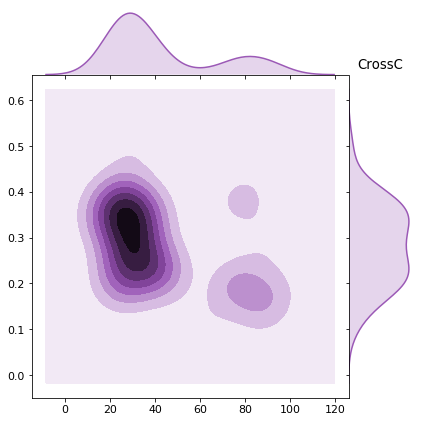

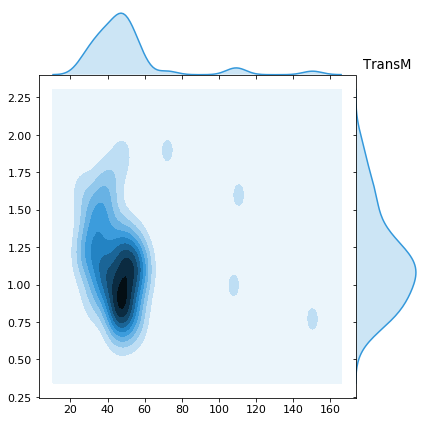

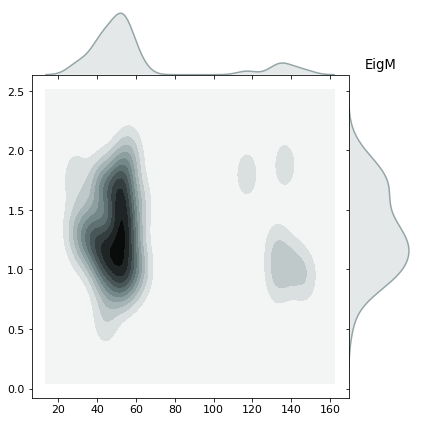

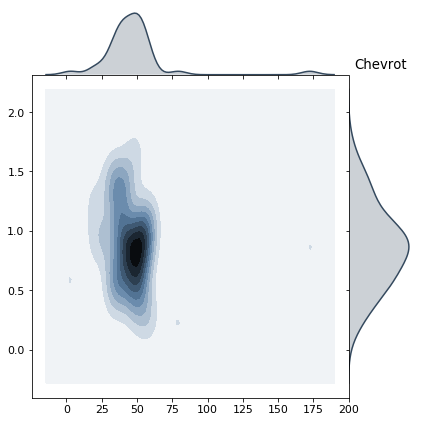

In [32]:
## different ways to present this

#fig,ax = plt.figure(figsize=(16,9))
#plt.subplot(2,2,1)
#plt.hist2d(best_val_1[:,0],best_val_1[:,2],bins=(20,10),cmap='plasma')
sns.jointplot(best_val_1[:,0], best_val_1[:,2],kind="kde", space=0, color="#9b59b6")
plt.title('CrossC')

#plt.subplot(2,2,2)
sns.jointplot(best_val_2[:,0], best_val_2[:,2],kind="kde", space=0, color="#3498db")
#plt.hist2d(best_val_2[:,0],best_val_2[:,2],bins=(20,10),cmap='plasma')
plt.title('TransM')

# plt.subplot(2,2,3)
sns.jointplot(best_val_3[:,0], best_val_3[:,2],kind="kde", space=0, color="#95a5a6")
# #plt.hist2d(best_val_3[:,0],best_val_3[:,2],bins=(20,10),cmap='plasma')
plt.title('EigM')

# plt.subplot(2,2,4)
sns.jointplot(fast_dir_chev, dt,kind="kde", space=0, color="#34495e")

plt.title('Chevrot')

# #plt.hist2d(fast_dir_chev,dt,bins=(20,10),cmap='plasma')

#plt.colorbar()




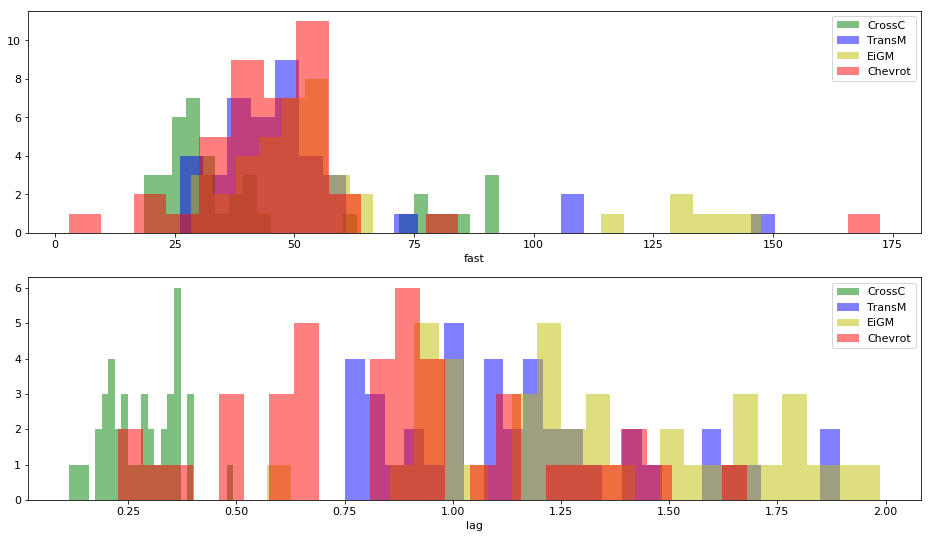

In [536]:
## best val of method is now the unweighted median

plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
bins=25
plt.hist(best_val_1[:,0],bins=bins,color='green',alpha=0.5,label='CrossC')
plt.hist(best_val_2[:,0],bins=bins,color='b',alpha=0.5,label='TransM')
plt.hist(best_val_3[:,0],color='y',bins=bins,alpha=0.5,label='EiGM')
plt.hist(fast_dir_chev,color='red',alpha=0.5,bins=bins,label='Chevrot')
plt.xlabel('fast')
plt.legend()

plt.subplot(2,1,2)
plt.hist(best_val_1[:,2],bins=bins,color='green',alpha=0.5,label='CrossC')
plt.hist(best_val_2[:,2],color='b',bins=bins,alpha=0.5,label='TransM')
plt.hist(best_val_3[:,2],color='y',alpha=0.5,bins=bins,label='EiGM')
plt.hist(dt,color='red',bins=bins,alpha=0.5,label='Chevrot')
plt.xlabel('lag')
plt.legend()
plt.show()





  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 5147.96it/s]

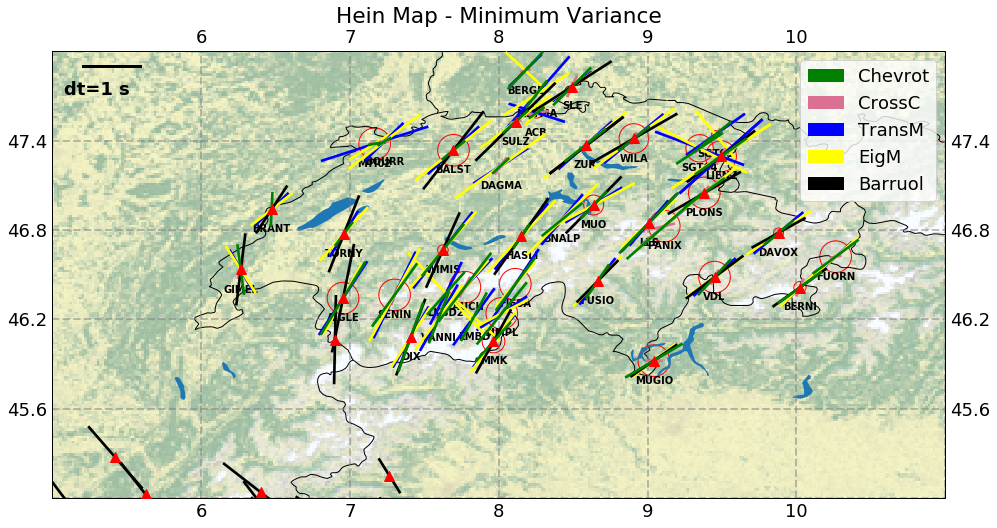

In [598]:
#########################################################################################################
### PLOTTING RESULTS HERE
#########################################################################################################
## make Topographic one
##### MOVE ALL THE PLOTTING DOWN HERE
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
#from scalebar import scale_bar

figpath='/media/hein/home2/SplitWave_Results/Project_images'

plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 18})

proj = ccrs.PlateCarree()

ax = plt.axes(projection=proj)
#ax = plt.axes([0.2,0.2,0.75,0.75])
ax.set_extent([5, 11, 45, 48],proj)
#ax.set_extent([4, 11, 42, 48],proj)
#ax = fig.add_axes([0.2,0.2,0.75,0.75])    
#ax.set_extent([0, 45, 0, 90],proj)

places =  cfeature.NaturalEarthFeature('cultural','populated_places','10m',facecolor='black')
land = cfeature.NaturalEarthFeature('physical','land','10m',
            edgecolor='k',facecolor='lightgoldenrodyellow',)

rivers = cfeature.NaturalEarthFeature(category='physical',name='rivers_lake_centerlines',scale='110m')

graticules = cfeature.NaturalEarthFeature(category='physical',name='graticules_1',scale='110m',facecolor='gray')
bounding_box = cfeature.NaturalEarthFeature(category='physical',name='wgs84_bounding_box',scale='10m',facecolor='none')
physical_building_blocks = cfeature.NaturalEarthFeature(category='physical',name='land_ocean_label_points',scale='10m',facecolor='gray')


geography_regions_points=cfeature.NaturalEarthFeature(
    category='physical',
    name='geography_regions_elevation_points',
    scale='10m',
    facecolor='black')

borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land','10m',
            edgecolor='black',facecolor='none')
lakes = cfeature.NaturalEarthFeature(category='physical',name='lakes_europe',scale='10m')
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
geoprahic_lines = cfeature.NaturalEarthFeature(
    category='physical',
    name='geographic_lines',
    scale='10m',
    facecolor='black')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(lakes)
ax.add_feature(states_provinces, edgecolor='none')
ax.add_feature(borders)
#ax.add_feature(geoprahic_lines)#
#ax.add_feature(graticules)
#ax.add_feature(geography_regions_points)

## CHANGE BACKROUND HERE
#ax.background_img()
#ax.background_img(name='gray-earth', resolution='low')
keyword = ['gray-earth','topography','ne_shaded_real','NE1_HR']
keyword = keyword[3]
ax.background_img(name=keyword, resolution='low')
#ax.background_img(name='NE1_HR', resolution='low')
#ax.background_img(name='ne_shaded_real', resolution='low')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
#########################################################################################################
### CHANGE COORDINATES HERE
## needed lat,lon,station,fast,dt, xi for ball, error for more quiver
path = '/media/hein/home2/SKS_automatic_splitwave/code_latest/'
station,lat,lon,fast,dfast,lag,dlag,nSKS = load_in_Barruol_table(path)

#########################################################################################################
### PLOT BARRUOL
ARROW_SCALE = 15
#########################################################################################################
ax.plot(lon,lat,'^r',transform=ccrs.PlateCarree(),markersize=10,zorder=11)
    

# r = lag
# r2 =lag +dlag
# phi = fast
# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     u2,v2 = calc_u_v(r2[i],phi[i])
#     ax.quiver(lon[i], lat[i], u, v,pivot='mid',color='black',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE) 
#     ax.quiver(lon[i], lat[i], u2, v2,pivot='mid',color='black',width=0.001, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)                 
    
# ## + ERROR    
# r = lag
# phi = fast+dfast
# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     ax.quiver(lon[i], lat[i], u, v,pivot='mid',color='black',width=0.001, linestyle='-', zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    
# ## - ERROR    
# r = lag
# phi = fast-dfast
# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     ax.quiver(lon[i], lat[i], u, v,pivot='mid',color='black',width=0.001, linestyle='-', zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         

        
# ax.quiver(lon[i], lat[i], u, v,pivot='mid',color='black',width=0.003, zorder=10,headlength=0, headwidth = 1,label='Barruol')

### READ IN THE OTHER METHODS AND PLOT BEST RESULTS PER STATION, 

## function to load in  the coordinates 
st_ch,st_lat,st_lon = get_Swiss_station_coordinates()


#########################################################################################################
### READ IN THE CHEVROT RESULTS
# path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT'
# #filename = 'SKS_Splitting_Chevrot_copy.txt'
# filename = 'SKS_Splitting_Chevrot.txt'

#station_chev,dt,dtlag,fast_dir,dfast_dir,best_twin,chi_phi,p_phi,chi_dt,p_dt,n_events = read_SKS_files(path,filename)
path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT'
filename = 'SKS_Splitting_Chevrot.txt'
station_chev,dt,dtlag,fast_dir,dfast_dir,best_twin,chi_phi,p_phi,chi_dt,p_dt,n_events = read_SKS_files(path,filename)

# r = dt
# r2 =dt+dtlag
# phi = fast_dir
r = dt
r1 = best_val_1[:,2]
r2 = best_val_2[:,2]
r3 = best_val_3[:,2]

phi = fast_dir_chev
phi1 = best_val_1[:,0]
phi2 = best_val_2[:,0]
phi3 = best_val_3[:,0]

## go through station list

## take best_vals and make arrows
for i in range(0,len(phi)):
    u,v = calc_u_v(r[i],phi[i])
    u1,v1 = calc_u_v(r1[i],phi1[i])
    u2,v2 = calc_u_v(r2[i],phi2[i])
    u3,v3 = calc_u_v(r3[i],phi3[i])
    
    
    plt.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='green',width=0.003, zorder=11,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    plt.quiver(st_lon[i], st_lat[i], u1, v1,pivot='mid',color='palevioletred',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    plt.quiver(st_lon[i], st_lat[i], u2, v2,pivot='mid',color='blue',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    plt.quiver(st_lon[i], st_lat[i], u3, v3,pivot='mid',color='yellow',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)             


plt.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='green',width=0.004, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='Chevrot')         
plt.quiver(st_lon[i], st_lat[i], u1, v1,pivot='mid',color='palevioletred',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='CrossC')         
plt.quiver(st_lon[i], st_lat[i], u2, v2,pivot='mid',color='blue',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='TransM')         
plt.quiver(st_lon[i], st_lat[i], u3, v3,pivot='mid',color='yellow',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='EigM')             


#####################################
### BARRUOL
path = '/media/hein/home2/SKS_automatic_splitwave/code_latest/'
station_barr,lat,lon,fast_barr,dfast_barr,lag_barr,dlag_barr,nSKS = load_in_Barruol_table(path)

r = lag_barr
phi = fast_barr

for i in range(0,len(phi)):
    u,v = calc_u_v(r[i],phi[i])
    plt.quiver(lon[i], lat[i], u, v,pivot='mid',color='black',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE) 
plt.quiver(lon[i], lat[i], u, v,pivot='mid',color='black',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='Barruol')     

    
factor=1e3
ax.scatter(st_lon, st_lat, s=p_phi*factor, facecolors='none', edgecolors='r')

for i in range(0,len(st_ch)):
    ax.annotate(st_ch[i],(st_lon[i],st_lat[i]-0.1),transform=ccrs.PlateCarree(),
        ha='center',va='top',weight='bold', fontsize=10)    
    
#########################################################################################################
ax.quiver(5+0.2,48-0.1,1,0,width=0.003,color='black',headlength=0, headwidth = 1, scale=ARROW_SCALE)
ax.annotate('dt=1 s',(5+0.3,48-0.2),transform=ccrs.PlateCarree(), ha='center',va='top',weight='bold')
#########################################################################################################

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles,labels=labels)
ax.set_title('Hein Map - Minimum Variance',x=0.5,y=1.05)
plt.savefig('{0}/Resulting_Map_compare_{1}.png'.format(figpath,keyword),dpi=150)

plt.show()
#########################################################################################################

############# For Smaller Plot
#ax.background_img(name='BM', resolution='low')
#ax.background_img()
#ext = [5, 11, 45, 48]

# sub_ax = plt.axes([0.55,0.12,0.25,0.25], projection=proj)
# # Add coastlines and background
# sub_ax.coastlines()
# sub_ax.background_img()
# # Plot box with position of main map
# extent_box = sgeom.box(ext[0],ext[2],ext[1],ext[3])

# sub_ax.add_geometries([extent_box], proj, color='none',
#                       edgecolor='red', linewidth=3)

# sub_ax.background_img()
# sub_ax.plot(ev_lon,ev_lat,'*y',transform=proj,markersize=7)
#scale_bar(ax,(0.75,0.05),10)

### plot EQ location and Great circle path

# r = dt
# r2 =dt+dtlag
# phi = fast_dir

# ### ORANGE OR R3 is METHOD
# r3 = best_val_1[:,2]
# phi3 = best_val_1[:,0]

# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     u2,v2 = calc_u_v(r2[i],phi[i])
#     u3,v3 = calc_u_v(r3[i],phi3[i])
    
#     ax.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='lime',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
#     ax.quiver(st_lon[i], st_lat[i], u2, v2,pivot='mid',color='lime',width=0.001, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)             
#     ax.quiver(st_lon[i], st_lat[i], u3, v3,pivot='mid',color='orange',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)                 

# ## + ERROR    
# r = dt
# phi = fast_dir+dfast_dir
# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     ax.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='lime',width=0.001, linestyle='-', zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    
# ## - ERROR    
# r = dt
# phi = fast_dir-dfast_dir
# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     ax.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='lime',width=0.001, linestyle='-', zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)        



In [9]:
## next to dos
## read about Inversion of Time lag
## implement cluster analysis
## get the AlpArray Data and process through it 


[  1.50099916e-02   1.55723290e-16   1.00000000e+03   6.59519344e-01
   9.99999999e+02   9.99775609e+02   6.60535544e+01   1.26304795e+01
   9.99999794e+02   5.15670513e+02   7.46716725e-25   1.00000000e+03
   2.22288033e-12   1.07710231e+02   1.00000000e+03   7.25235411e+00
   7.51932879e+02   0.00000000e+00   9.80997514e+01   9.99999986e+02
   5.02511248e-02   9.99976304e+02   9.99974391e+02   8.75992495e+02
   1.47078443e+02   3.96144564e+02   2.89932971e-01   9.94780864e+02
   8.46068367e-04   2.60470491e+01   4.25788806e-10   1.76255636e-24
   0.00000000e+00   6.76795193e-12   9.99368896e+02   1.58228323e+01
   6.00366681e+01   9.99999941e+02   3.92128002e-02   9.57000413e+02]


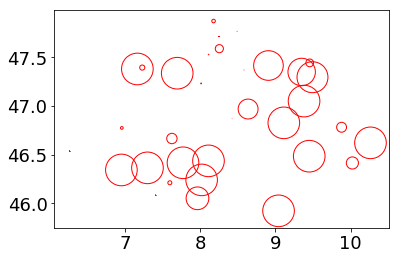

In [121]:
factor=1e3
print(p_phi*factor)
plt.scatter(st_lon, st_lat, s=p_phi*factor, facecolors='none', edgecolors='r')
plt.scatter(lon, lat, s=p_phi*factor, facecolors='none', edgecolors='r')




  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 3761.88it/s]

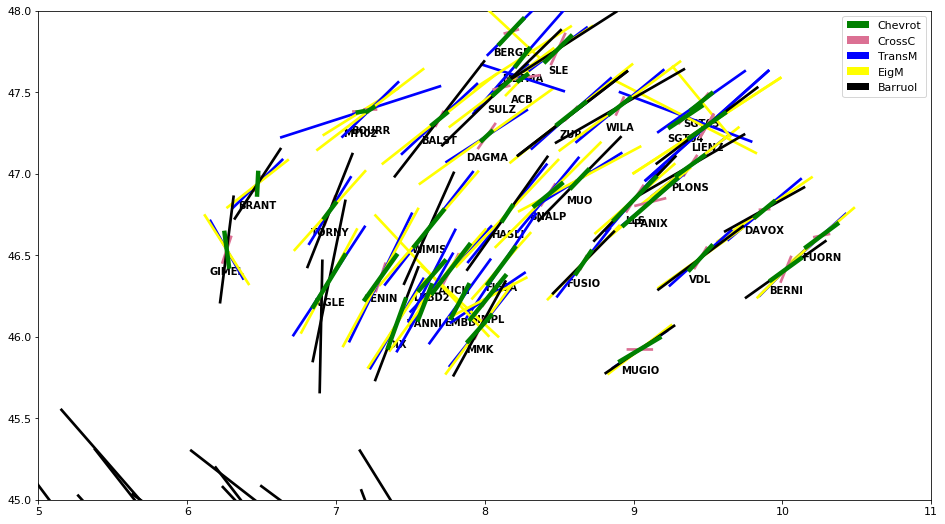

In [557]:
### ERROR SPREAD
st_ch,st_lat,st_lon = get_Swiss_station_coordinates()

path = '/media/hein/home2/SplitWave_Results/Splitws/Time_Window_Test/TXT'
filename = 'SKS_Splitting_Chevrot_copy.txt'
station_chev,dt,dtlag,fast_dir,dfast_dir,best_twin,chi_phi,p_phi,chi_dt,p_dt,n_events = read_SKS_files(path,filename)

ARROW_SCALE=1e1
plt.figure(figsize=(16,9))
# r = dt
# r2 =dt+dtlag
# phi = fast_dir
r = dt
r1 = best_val_1[:,2]
r2 = best_val_2[:,2]
r3 = best_val_3[:,2]

phi = fast_dir_chev
phi1 = best_val_1[:,0]
phi2 = best_val_2[:,0]
phi3 = best_val_3[:,0]

## go through station list

## take best_vals and make arrows
for i in range(0,len(phi)):
    u,v = calc_u_v(r[i],phi[i])
    u1,v1 = calc_u_v(r1[i],phi1[i])
    u2,v2 = calc_u_v(r2[i],phi2[i])
    u3,v3 = calc_u_v(r3[i],phi3[i])
    
    
    plt.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='green',width=0.005, zorder=11,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    plt.quiver(st_lon[i], st_lat[i], u1, v1,pivot='mid',color='palevioletred',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    plt.quiver(st_lon[i], st_lat[i], u2, v2,pivot='mid',color='blue',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    plt.quiver(st_lon[i], st_lat[i], u3, v3,pivot='mid',color='yellow',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)             


plt.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='green',width=0.004, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='Chevrot')         
plt.quiver(st_lon[i], st_lat[i], u1, v1,pivot='mid',color='palevioletred',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='CrossC')         
plt.quiver(st_lon[i], st_lat[i], u2, v2,pivot='mid',color='blue',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='TransM')         
plt.quiver(st_lon[i], st_lat[i], u3, v3,pivot='mid',color='yellow',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='EigM')             


#####################################
### BARRUOL
path = '/media/hein/home2/SKS_automatic_splitwave/code_latest/'
station_barr,lat,lon,fast_barr,dfast_barr,lag_barr,dlag_barr,nSKS = load_in_Barruol_table(path)

r = lag_barr
phi = fast_barr

for i in range(0,len(phi)):
    u,v = calc_u_v(r[i],phi[i])
    plt.quiver(lon[i], lat[i], u, v,pivot='mid',color='black',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE) 
plt.quiver(lon[i], lat[i], u, v,pivot='mid',color='black',width=0.003, zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE,label='Barruol')     
    
#####################################
# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     plt.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='lime',width=0.001, linestyle='-', zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)         
    


# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     plt.quiver(st_lon[i], st_lat[i], u, v,pivot='mid',color='lime',width=0.001, linestyle='-', zorder=10,headlength=0, headwidth = 1, scale=ARROW_SCALE)        



for i in range(0,len(st_ch)):
    plt.annotate(st_ch[i],(st_lon[i],st_lat[i]-0.1),transform=ccrs.PlateCarree(),
        ha='center',va='top',weight='bold', fontsize=10)    

#5, 11, 45, 48    
plt.xlim(5,11)
plt.ylim(45,48)
plt.legend()
plt.show()



In [538]:
##################
################## OLD
##################
save_loc = '/media/hein/home2/SplitWave_Data'
print(save_loc)


FMT = 'SAC'
Splitting_windows = True
plot_SplitW = False
mod = 'ak135' ##mod = 'iasp91'
model = TauPyModel(model=mod)

new_stat_list = os.listdir(save_loc) ## Get A list of downloaded Stations

### CHOOSE STATION and load all waveforms 
method= 'Chevrot'
write_head_CHEV(txt_path, method,header2)

########################################################################################################################################################################
########################################################################################################################################################################
#for istation in range(0,len(new_stat_list)):
#for istation in range(32,len(new_stat_list)):    
for istation in range(0,1):    
### LOOOP AROUND    
    station = new_stat_list[istation]

    print('Loading in Waveforms')
    st_ev = obspy.Stream()
    st_ev,st_lat_l,st_lon_l,ev_lat_l,ev_lon_l,ev_time_l,ev_depth_l,ev_mag_l,ev_dist_l,back_azimut_l, t_SKS_l,t_SKKS_l,t_PP_l = read_station_event_data(station)
    ########################################################################################################################################################################
    ########################################################################################################################################################################
    ### MAIN FUNCTION TO FIRST CALCULATE CHEVROT FOR ALL EVENTS

    ntwindows = 60  ### test 50 timw windows

    Az_l  = np.zeros((len(ev_time_l),ntwindows))
    SV_Az_l = np.zeros((len(ev_time_l),ntwindows))



    for nevent in range(0,len(ev_time_l)):
    #for nevent in range(0,3):    

        st_cut = n_event_st_cut(nevent)
        t_SKS_real = get_real_SKS_arrival(st_cut)
        ### BLOCK FOR CHEVROT

        twindows = np.linspace(1,90,ntwindows)
        
        #twindows = 0.1

        for iwindow in range(0,len(twindows)):
        #    print(twindows[iwindow])

            Az,SV_Az = SKS_Intensity_Chevrot(st_cut,ev_time_l[nevent],float(t_SKS_real)-float(ev_time_l[nevent]),back_azimut_l[nevent],twindows[iwindow],plot=False)
            Az_l[nevent,iwindow] = Az
            SV_Az_l[nevent,iwindow] = SV_Az



    val_4 = np.zeros((ntwindows,4))

    for iwin in range(0,len(twindows)):

        dt,phi,std_dt,std_phi = get_best_dt_and_phi(Az_l[:,iwin],SV_Az_l[:,iwin],st_cut[0].stats.station)
        val_4[iwin,:] = (dt,phi,std_dt,std_phi)
            ## write out results for Chevrot

    #### CHI2 TEST
    chisquare_dt4,p_dt4 = stats.chisquare(val_4[:,0])
    chisquare_phi4,p_phi4 = stats.chisquare((val_4[:,1]+360)%180)                           


    vals = [str(st_cut[0].stats.station),
           val_4[np.argmin(val_4[:,3]),1],
           val_4[np.argmin(val_4[:,3]),3],
           val_4[np.argmin(val_4[:,2]),0],
           val_4[np.argmin(val_4[:,2]),2],
           chisquare_phi4,
           p_phi4,
           chisquare_dt4,
           p_phi4,
           len(ev_time_l)]
    method = 'Chevrot'    
    write_SKS_Results_CHEV(txt_path, method, vals, header2) 
    


(40, 2)


In [ ]:
# ## OLD 
# ## improve Map
# ## make Topographic one
# ##### MOVE ALL THE PLOTTING DOWN HERE
# ### to make a map of study area
# import cartopy
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.pyplot as plt
# import shapely.geometry as sgeom
# #from scalebar import scale_bar

# figpath='/media/hein/home2/SplitWave_Results/Project_images'


# ## use topography map?
# plt.figure(figsize=(16,9))

# proj = ccrs.PlateCarree()

# ax = plt.axes(projection=proj)
# #ax = plt.axes([0.2,0.2,0.75,0.75])
# #ax.set_extent([5, 11, 45, 48],proj)
# ax.set_extent([4, 11, 42, 48],proj)

# #ax = fig.add_axes([0.2,0.2,0.75,0.75])    


# #ax.set_extent([0, 45, 0, 90],proj)

# places =  cfeature.NaturalEarthFeature('cultural','populated_places','10m',facecolor='black')
# land = cfeature.NaturalEarthFeature('physical','land','10m',
#             edgecolor='k',facecolor='lightgoldenrodyellow',)

# rivers = cfeature.NaturalEarthFeature(category='physical',name='rivers_lake_centerlines',scale='110m')

# graticules = cfeature.NaturalEarthFeature(category='physical',name='graticules_1',scale='110m',facecolor='gray')
# bounding_box = cfeature.NaturalEarthFeature(category='physical',name='wgs84_bounding_box',scale='10m',facecolor='none')
# physical_building_blocks = cfeature.NaturalEarthFeature(category='physical',name='land_ocean_label_points',scale='10m',facecolor='gray')


# geography_regions_points=cfeature.NaturalEarthFeature(
#     category='physical',
#     name='geography_regions_elevation_points',
#     scale='10m',
#     facecolor='black')

# borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land','10m',
#             edgecolor='black',facecolor='none')
# lakes = cfeature.NaturalEarthFeature(category='physical',name='lakes_europe',scale='10m')
# states_provinces = cfeature.NaturalEarthFeature(
#     category='cultural',
#     name='admin_1_states_provinces_lines',
#     scale='10m',
#     facecolor='none')
# geoprahic_lines = cfeature.NaturalEarthFeature(
#     category='physical',
#     name='geographic_lines',
#     scale='10m',
#     facecolor='black')





# SOURCE = 'Natural Earth'
# LICENSE = 'public domain'

# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)

# #ax.add_feature(rivers)
# ax.add_feature(lakes)
# ax.add_feature(states_provinces, edgecolor='none')
# ax.add_feature(borders)
# #ax.add_feature(geoprahic_lines)#
# #ax.add_feature(graticules)
# #ax.add_feature(geography_regions_points)

# #ax.background_img()
# ax.background_img(name='gray-earth', resolution='low')

# ax.plot(lon,lat,'^r',transform=ccrs.PlateCarree(),markersize=10,zorder=11)

# for i in range(0,len(station)):
#     ax.annotate(station[i],(lon[i],lat[i]-0.1),transform=ccrs.PlateCarree(),
#         ha='center',va='top',weight='bold')
    
# # r = dtlag
# # phi = fast_dir
# r = lag
# phi = fast

# for i in range(0,len(phi)):
#     u,v = calc_u_v(r[i],phi[i])
#     ax.quiver(lon[i], lat[i], u, v,pivot='mid',color='green',width=0.003, zorder=10)    
    
    
# ax.quiver(5+0.2,48-0.1,1,0,width=0.003,color='black')
# ax.annotate('dt=1 s',(5+0.3,48-0.2),transform=ccrs.PlateCarree(), ha='center',va='top',weight='bold')
# #ax.background_img(name='BM', resolution='low')
# #ax.background_img()
# ext = [5, 11, 45, 48]

# ############# For Small Plot

# # sub_ax = plt.axes([0.55,0.12,0.25,0.25], projection=proj)
# # # Add coastlines and background
# # sub_ax.coastlines()
# # sub_ax.background_img()
# # # Plot box with position of main map
# # extent_box = sgeom.box(ext[0],ext[2],ext[1],ext[3])

# # sub_ax.add_geometries([extent_box], proj, color='none',
# #                       edgecolor='red', linewidth=3)

# # sub_ax.background_img()
# # sub_ax.plot(ev_lon,ev_lat,'*y',transform=proj,markersize=7)
# #scale_bar(ax,(0.75,0.05),10)

# ### plot EQ location and Great circle path
# plt.savefig('{0}/Resulting_Map_Barruol.png'.format(figpath),dpi=150)
# plt.show()

